In [30]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import models
from torchvision.transforms import transforms
import torchvision.transforms.functional as TF
import torch.optim as optim
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
from google.colab import userdata

## Datasets

[ADE20K](https://www.kaggle.com/datasets/ipythonx/ade20k-scene-parsing)
- Image : jpg
- Mask : PNG


- - - -
**헷갈리는 점..
train, val은 Crop,
Test는 Resize..
뭔가 안맞을것 같은데..**

In [31]:
try:
    os.environ['KAGGLE_USERNAME'] = "lufthansa454"
    os.environ['KAGGLE_KEY'] = 'KGAT_2c8ff1dfe135f6b618f19f04faedfe72'
    print("User info being set")

    !kaggle datasets download -d ipythonx/ade20k-scene-parsing
    !unzip -q ade20k-scene-parsing.zip -d ade20k_data

    print("Dataset Download and Unzip Complete")
except:
    print("User info has not been set.")


User info being set
Dataset URL: https://www.kaggle.com/datasets/ipythonx/ade20k-scene-parsing
License(s): copyright-authors
ade20k-scene-parsing.zip: Skipping, found more recently modified local copy (use --force to force download)
replace ade20k_data/ADEChallengeData2016/annotations/training/ADE_train_00000001.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
A
Dataset Download and Unzip Complete


In [32]:
head_path = '/content/ade20k_data'
print(os.listdir(head_path))

['ADEChallengeData2016', 'release_test']


In [33]:
image_path = os.path.join(head_path, "ADEChallengeData2016/images")
mask_path = os.path.join(head_path, "ADEChallengeData2016/annotations")

print(os.listdir(image_path))

num_train_img = len(os.listdir(os.path.join(image_path, 'training')))
num_val_img = len(os.listdir(os.path.join(image_path, 'validation')))
num_test_img = len(os.listdir(os.path.join(head_path, 'release_test/testing')))

print(f"train 이미지 데이터 수 : {num_train_img}")
print(f"Validation 이미지 데이터 수 : {num_val_img}")
print(f"Test 이미지 데이터 수 : {num_test_img}")

['validation', 'training']
train 이미지 데이터 수 : 20210
Validation 이미지 데이터 수 : 2000
Test 이미지 데이터 수 : 3352


In [34]:
import os
from PIL import Image

training_dir = os.path.join(image_path, "training")

image_files = [
    f for f in os.listdir(training_dir)
    if f.lower().endswith(".jpg")
]

smallest_h = float("inf")
smallest_w = float("inf")

for image_file in image_files:
    img_path = os.path.join(training_dir, image_file)

    with Image.open(img_path) as img:
        w, h = img.size  # (width, height)

        if h < smallest_h:
            smallest_h = h
        if w < smallest_w:
            smallest_w = w

print(f"Smallest Height : {smallest_h}")
print(f"Smallest Width  : {smallest_w}")

Smallest Height : 96
Smallest Width  : 130


Image format : JPEG
Image size : (300, 225)
Image mode : RGB


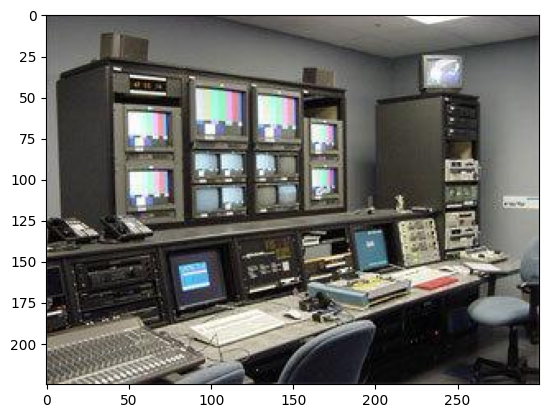

In [35]:
image_files = os.listdir(os.path.join(image_path, "training"))
image_files = [f for f in image_files if f.lower().endswith("jpg")]

first_image_file = image_files[0]
first_image_path = os.path.join(os.path.join(image_path, "training"), first_image_file)
img = Image.open(first_image_path)
plt.imshow(img)
print(f"Image format : {img.format}")
print(f"Image size : {img.size}")
print(f"Image mode : {img.mode}")

In [36]:
train_transform = A.Compose([
    # train_transform은 다양성을 위한 무작위 변환에 초점을 맞춤.
    A.Resize(height=473, width=473),
    A.PadIfNeeded(min_height=473, min_width=473, border_mode=cv2.BORDER_CONSTANT,value=0, mask_value=0),
    A.RandomCrop(height=473, width=473),

    A.HorizontalFlip(p=0.5),

    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),

    ToTensorV2()
])

test_transform = A.Compose([
    A.Resize(height=473, width=473),
    A.CenterCrop(height=473, width=473),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

/tmp/ipython-input-140095545.py:4: UserWarning: Argument(s) 'value, mask_value' are not valid for transform PadIfNeeded
  A.PadIfNeeded(min_height=473, min_width=473, border_mode=cv2.BORDER_CONSTANT,value=0, mask_value=0),


In [37]:
# train_transform = transforms.Compose([
#     # train_transform은 다양성을 위한 무작위 변환에 초점을 맞춤.
#     # 224가 작다는 이야기가 있음.. 384, 473 중에서 다시 해보기
#     transforms.Resize(473),
#     transforms.RandomCrop(473, pad_if_needed=True, padding_mode='constant', fill=0),
#     transforms.RandomHorizontalFlip(p=0.5),

#     transforms.ToTensor(),
#     transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
# ])

# test_transform = transforms.Compose([
#     transforms.Resize(473),
#     transforms.CenterCrop(473),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
# ])

In [43]:
class CustomDataset(Dataset):
    def __init__(self, image_dir, mode='train', transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.mode = mode

        self.img_folder = os.path.join(self.image_dir, 'images', mode)
        self.mask_folder = os.path.join(self.image_dir, 'annotations', mode)

        self.img_files = sorted(os.listdir(self.img_folder))
        self.mask_files = sorted(os.listdir(self.mask_folder))

    def __len__ (self):
        return len(self.img_files)

    def __getitem__(self, index):
        image = Image.open(os.path.join(self.img_folder, self.img_files[index]))
        image = image.convert('RGB')
        image = np.array(image)

        mask = Image.open(os.path.join(self.mask_folder, self.mask_files[index]))
        mask = mask.convert('L')
        mask = np.array(mask)

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        return image, mask

In [48]:
class TestDataset(Dataset):
    def __init__(self, image_dir, mode='test', transform=None):
        self.image_dir = image_dir
        self.transform = transform

        self.img_folder = os.path.join(self.image_dir, mode)
        self.img_files = sorted(os.listdir(self.img_folder))

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, index):
        img_name = self.img_files[index]
        image_path = os.path.join(self.img_folder, img_name)
        image = Image.open(image_path).convert('RGB')

        image = np.array(image)

        if self.transform:
            augmented = self.transform(image=image)
            image=augmented['image']
        return image, img_name

In [49]:
train_dataset = CustomDataset(image_dir=os.path.join(head_path, 'ADEChallengeData2016'), mode='training', transform=train_transform)
val_dataset = CustomDataset(image_dir = os.path.join(head_path, 'ADEChallengeData2016'), mode='validation', transform=test_transform)
test_dataset = TestDataset(image_dir = os.path.join(head_path, 'release_test'), mode='testing', transform=test_transform)

In [50]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=2)

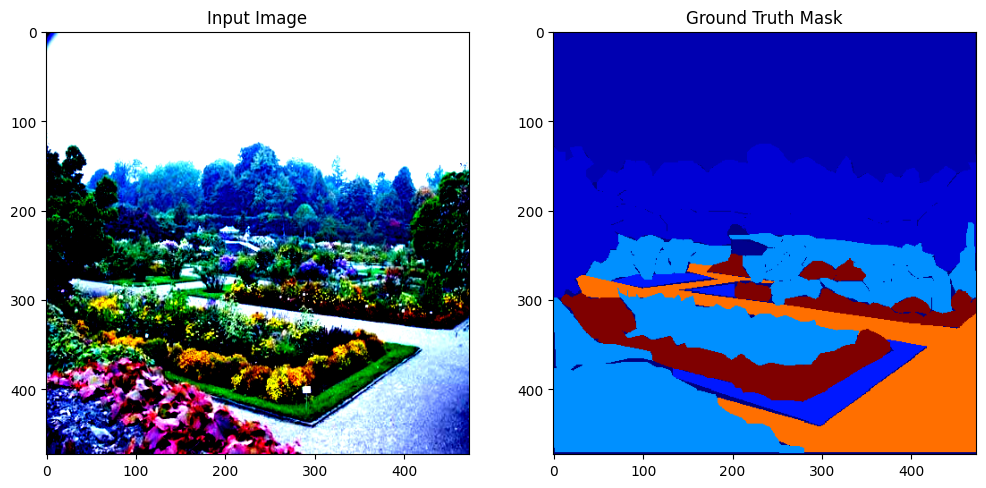

In [56]:
dataiter = iter(train_loader)
images, masks = next(dataiter)
img_tensor = images[0]
mask_tensor = masks[0]

img_show = img_tensor.permute(1, 2, 0).numpy()
mask_show = mask_tensor.squeeze().numpy()

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(img_show)
ax[0].set_title("Input Image")

ax[1].imshow(mask_show, cmap='jet')
ax[1].set_title("Ground Truth Mask")
plt.show()

## Backbone 모델 : ResNet50
- Classification용 ResNet 말고 Segmentation용 ResNet이 필요함
- 우리는 위치 정보가 필요하기 때문에 ResNet의 `avgpool`과 `fc`는 잘라낸다
  - `avgpool` (Global Average Pooling) : ResNet 끝에 있는 `avgpool` 은 15x15의 Feature Map을 1x1로 축소 시킴
  
  -> 위치 정보(공간 정보)는 삭제하고 사물이 있다는 요약 정보만 남김
  - `fc` (Fully Connected Layer) : 요약 정보를 가지고 확률을 계산한다.
`avgpool`을 통과하는 순간 위치 정보가 사라지기 때문에 `layer4`까지만 통과시키고, 그 결과물의 Feature Map을 그대로 가져와야 한다.

In [ ]:
def get_backbone(layers):
    if layers == 50:
        weights = models.ResNet50_Weights.DEFAULT
        backbone = models.resnet50(
            weights=weights,
            replace_stride_with_dilation=[False, True, True]
        )
    elif layers == 101:
        weights = models.ResNet101_Weights.DEFAULT
        backbone = models.resnet101(
            weights=weights,
            replace_stride_with_dilation=[False, True, True]
        )

        backbone_layers = list(backbone.children())[:-2]
        backbone = nn.Sequential(*backbone_layers)

    return backbone

In [ ]:
class PPM(nn.Module):
    def __init__ (self, in_channels, sizes=[1, 2, 3, 6]):
        super().__init__()
        self.stages = nn.ModuleList([])

        # Context Representation의 차원 수를 원래 특징 맵 차원의 1/N으로 줄여야 함. (N : 피라미드 레벨 수 (4))
        out_channels = int(in_channels/ len(sizes))

        for size in sizes:
            self.stages.append(nn.Sequential(
                nn.AdaptiveAvgPool2d(output_size=(size, size)),
                nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False), # 풀링 이후 이어지는 1x1 conv
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            ))
    def forward(self, x):
        layers = [x]
        for stage in self.stages:
            p = stage(x)
            # Upsampling : Bilinear Interpolation 수행
            p = F.interpolate(p, size=x.shape[2:], mode='bilinear', align_corners=False)
            layers.append(p)
        return torch.cat(layers, dim=1)


In [ ]:
class PSPN(nn.Module):
    def __init__(self, layers=50, classes=21): # Backbone으로 몇 층 짜리 모델을 사용할 것인가? : 50
        super().__init__()

        # Backbone
        self.backbone = get_backbone(layers)
        self.in_channels=2048 # ResNet50/101의 마지막 채널 수

        # PPM (Neck)
        # 7x7x2048 의 Feature Map을 받아서 AdaptiveAveragePool2d()로 쪼개기
        self.ppm = PPM(in_channels=self.in_channels)

        # Decoder (Head)
        # 현재 채널 : (2048 + 514*2 = 4096)
        # CrossEntropyLoss를 쓸 예정이니, 클래스 개수대로 채널 수 맞추기 (내부에서 LogSoftmax 사용)
        self.cls = nn.Sequential(
            nn.Conv2d(4096, 512, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Dropout2d(0.1),
            nn.Conv2d(512, classes, kernel_size=1)
            # Flatten 거치고 Fully-Connected Layer로 하면 안됨
            # : (x,y)의 좌표 개념이 사라져버림 -> Spatial Info 사라짐
        )

    def forward(self, x):
        x = self.backbone(x)

        x = self.ppm(x)

        x = self.cls(x)

        x = F.interpolate(x, scale_factor=8, mode='bilinear', align_corners=False)
        # 왜 Interpolate를 한번 더 하는거지..?
        # Ssi-bal

        return x